In [1]:
import sys
from cifar_very_tiny import *
from cifar_tiny import *
from cifar_dataset import *   
from resnet import * 
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import torch.nn as nn
import torch.nn.functional as F
import optuna

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
train_loader, test_loader = cifar10_loader(batch_size=128, maxsize=10112)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch_num = 30

In [4]:
def accuracy(model):
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.eq(torch.argmax(out, 1), y).sum()
            total += len(x)
    return (correct / total).cpu().detach().numpy()

In [5]:
kl = nn.KLDivLoss(reduction="batchmean")
sm = nn.Softmax(dim=1)

def distill(out, teacher_out, temp):
    g = sm(out / temp)
    f = F.log_softmax(teacher_out / temp)
    return kl(f, g)

  0%|          | 0/30 [00:00<?, ?it/s]

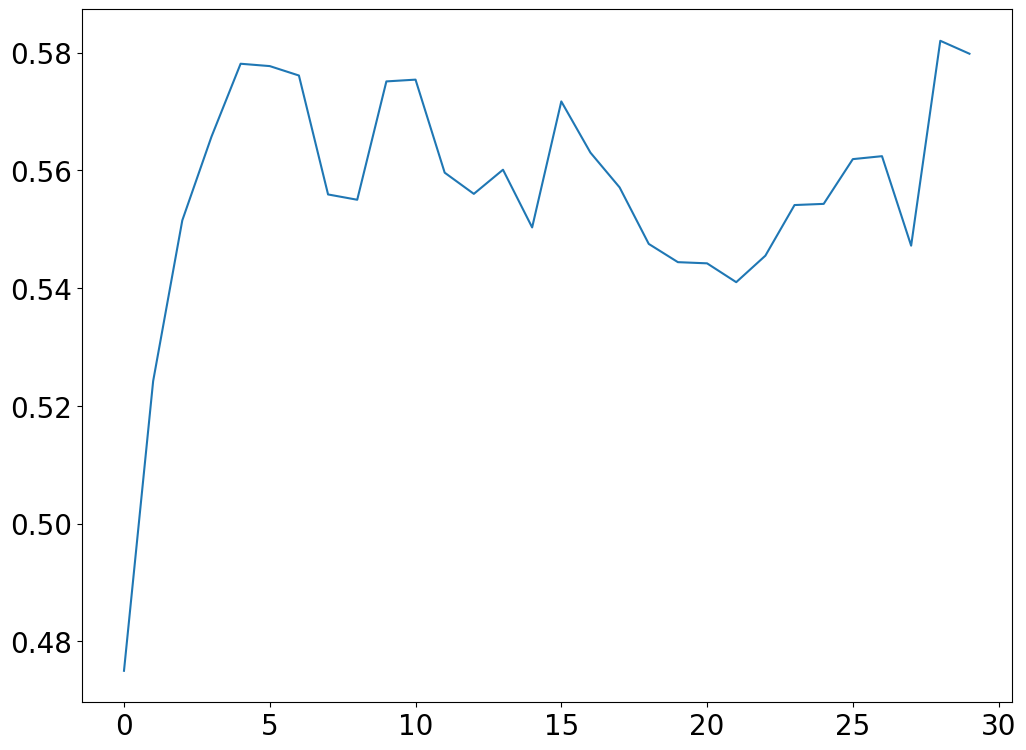

In [6]:
teacher = Cifar_Tiny(10).to(device)
optim = torch.optim.Adam(teacher.parameters())
crit = nn.CrossEntropyLoss()
tq = tqdm(range(epoch_num))

teacher_accuracy = []
for epoch in tq:
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        teacher.zero_grad()
        out = teacher(x)
        loss = crit(teacher(x), y)
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        optim.step()
    tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:])))
    teacher.eval()
    teacher_accuracy.append(accuracy(teacher))
    teacher.train()
plt.plot(teacher_accuracy)


  0%|          | 0/30 [00:00<?, ?it/s]

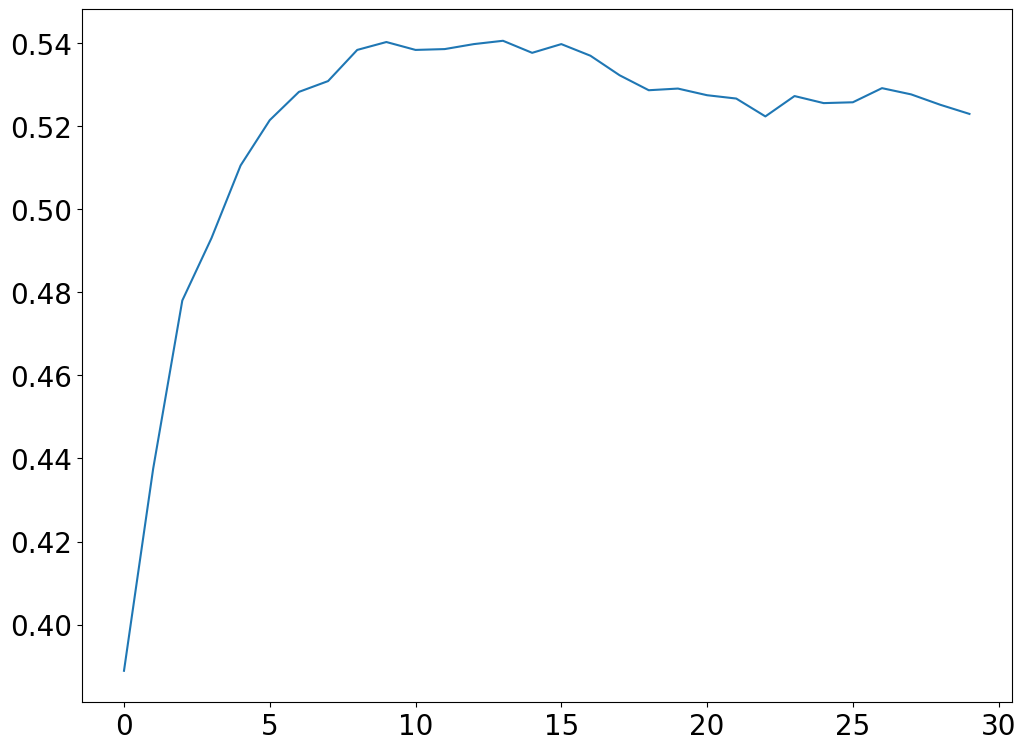

In [18]:
student = Cifar_Very_Tiny(10).to(device)
optim = torch.optim.Adam(student.parameters())
crit = nn.CrossEntropyLoss()
tq = tqdm(range(epoch_num))
cifar_very_tiny_accuracy = []
for epoch in tq:
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        student.zero_grad()
        out = student(x)
        loss = crit(student(x), y)
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        optim.step()
    tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:])))
    student.eval()
    cifar_very_tiny_accuracy.append(accuracy(student))
    student.train()
plt.plot(cifar_very_tiny_accuracy)

hyperparameters 0.5 3


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_14715/2137037151.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(teacher_out / temp)


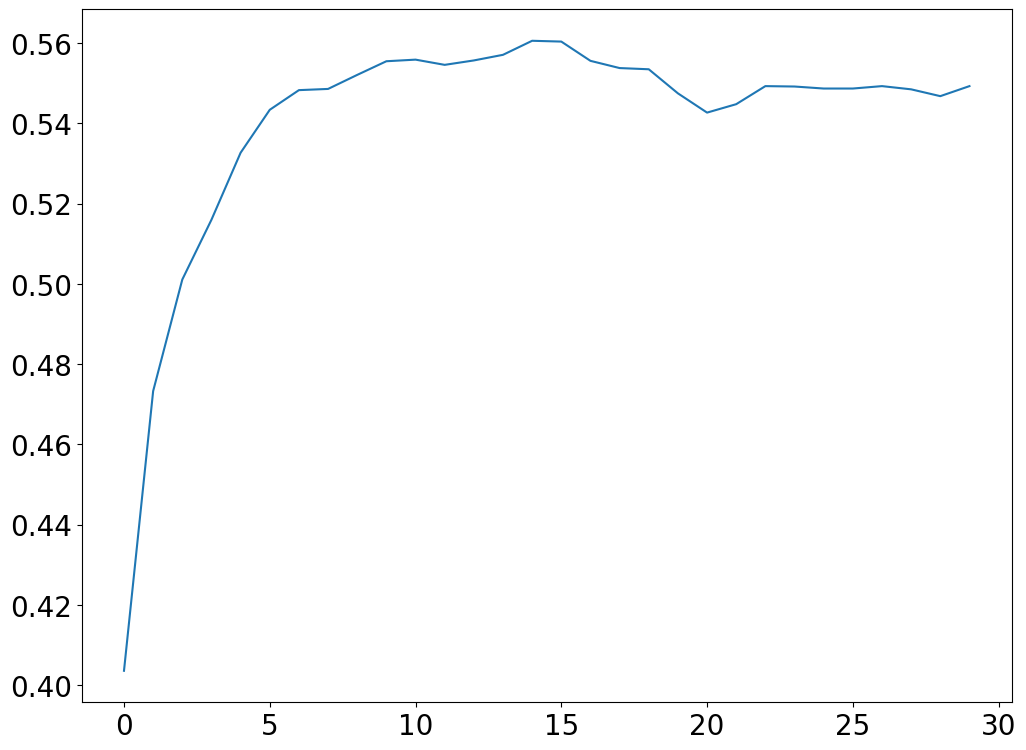

In [19]:
## Train students with Hinton distillation
### Very Tiny Student
beta = 0.5
temp = 3
print("hyperparameters", beta, temp)
student = Cifar_Very_Tiny(10).to(device)
optim = torch.optim.Adam(student.parameters())
crit = nn.CrossEntropyLoss()
tq = tqdm(range(epoch_num))
hinton_very_tiny_accuracy = []
for _ in tq:
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        student.zero_grad()
        out = student(x)
        with torch.no_grad():
            teacher_out = teacher(x)
        student_loss = crit(student(x), y)
        distillation_loss = distill(out, teacher_out, temp)
        loss = (1 - beta) * student_loss + beta * distillation_loss
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        optim.step()
    tq.set_description("current loss:{}".format(np.mean(losses[-10:])))
    student.eval()
    hinton_very_tiny_accuracy.append(accuracy(student))
    student.train()
plt.plot(hinton_very_tiny_accuracy)

In [13]:
class Mutual_Info(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Mutual_Info, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 2 * in_channels, kernel_size=1)
        self.conv1_bn = nn.BatchNorm2d(2 * in_channels)

        self.conv2 = nn.Conv2d(2 * in_channels, 2 * out_channels, kernel_size=1)
        self.conv2_bn = nn.BatchNorm2d(2 * out_channels)

        self.conv3 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=1)

    def forward(self, x):

        out = F.relu(self.conv1_bn(self.conv1(x)))

        out = F.relu(self.conv2_bn(self.conv2(out)))

        out = self.conv3(out)

        return out

In [24]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

In [32]:
crit = nn.CrossEntropyLoss()
for lam1 in tqdm(lambdas):
    student = Cifar_Very_Tiny(10).to(device)
    mu_feat = Mutual_Info(32, 64).to(device)
    log_sigma_feat = torch.nn.Parameter(torch.zeros(1).to(device))
    optim = torch.optim.Adam(list(student.parameters()) + list(mu_feat.parameters()) + [log_sigma_feat])    
    tq = tqdm(range(epoch_num))
    for epoch in tq:
        losses = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optim.zero_grad()
            student_feat, student_logits = student.get_features(x, [2, 4])
            teacher_feat, teacher_logits = teacher.get_features(x, [2, 4])
            mu_stud_feat = mu_feat(student_feat)
            mu_stud_feat = mu_stud_feat.view(mu_stud_feat.size(0), -1)
            teacher_feat = teacher_feat.view(teacher_feat.size(0), -1)
            class_loss = crit(student_logits, y)
            sigma2 = torch.log(1 + torch.exp(log_sigma_feat))
            feat_loss = ((teacher_feat - mu_stud_feat) ** 2).sum(
                1
            ).mean() / 2 * sigma2 + 0.5*torch.log(sigma2)
            loss = class_loss * (1.0-lam1) + feat_loss * lam1

            loss.backward()
            optim.step()
            losses.append(loss.detach().cpu().numpy())
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:]))) 
        #scheduler.step()
        student.eval()
        ac = accuracy(student)
        student.train()
        with open('../logs/acc_mi.txt','a') as out:
            out.write('{}: {}: {}\n'.format(lam1, epoch, ac))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [38]:
path = '../logs/acc_mi.txt'

with open(path, "r") as read_file:
    data = [float(line.split()[2]) for line in read_file]
data = np.reshape(np.array(data), (-1, epoch_num))

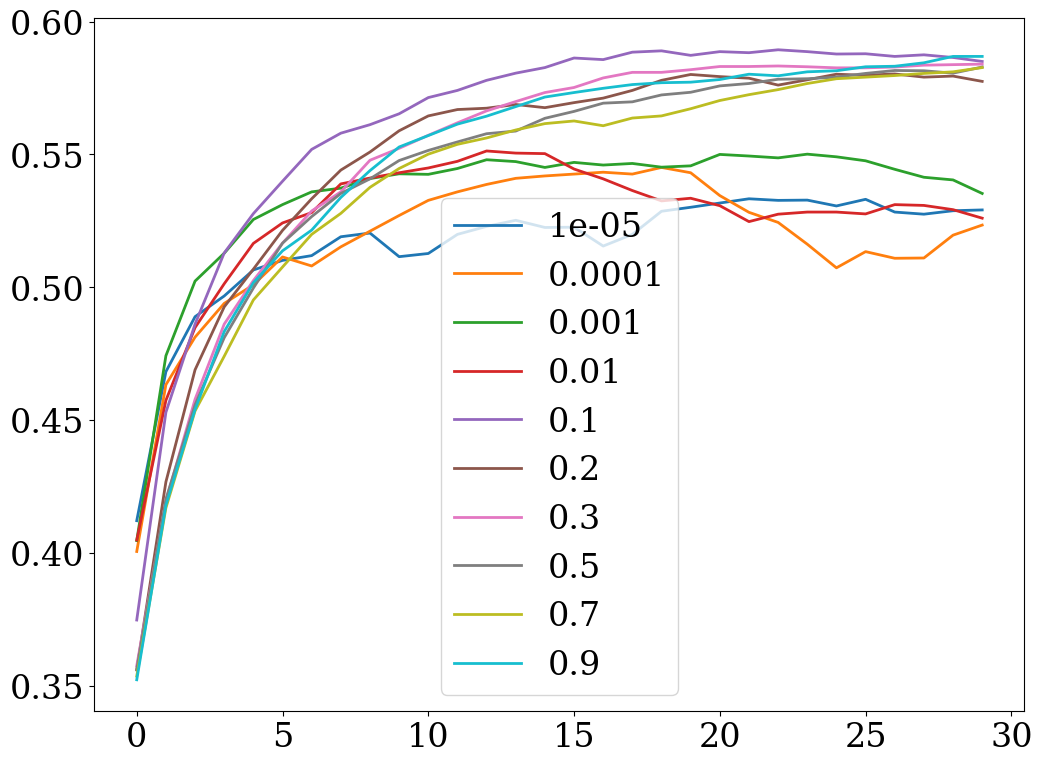

In [39]:


from matplotlib import pylab as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24


for i in range(len(lambdas)):
    plt.plot(data[i], label=str(lambdas[i]))
    plt.legend()

In [44]:
crit = nn.CrossEntropyLoss()
for lam1 in tqdm(lambdas):
    student = Cifar_Very_Tiny(10).to(device)
    
    my_feat = [Mutual_Info(8, 16).to(device),
               Mutual_Info(16, 32).to(device),
               Mutual_Info(32, 64).to(device),
               ]
    
    log_sigma_feat = [torch.nn.Parameter(torch.zeros(1).to(device)),
                      torch.nn.Parameter(torch.zeros(1).to(device)),
                      torch.nn.Parameter(torch.zeros(1).to(device)),
                    ]
    
    optim = torch.optim.Adam(list(student.parameters()) + list(my_feat[0].parameters()) + list(my_feat[1].parameters()) + list(my_feat[2].parameters()) +log_sigma_feat)    
    tq = tqdm(range(epoch_num))
    for epoch in tq:
        losses = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optim.zero_grad()
            
            
            *student_feat, student_logits = student.get_features(x, [0, 1, 2, 4])
            teacher_feat = teacher.get_features(x, [0, 1, 2])
            
            feat_loss_sum = 0
            for i in range(3):
                my_stud_feat = my_feat[i](student_feat[i])
                my_stud_feat = my_stud_feat.view(my_stud_feat.size(0), -1)
                my_teacher_feat = teacher_feat[i].view(teacher_feat[i].size(0), -1)
                
                sigma2 = torch.log(1 + torch.exp(log_sigma_feat[i]))
                feat_loss = ((my_teacher_feat - my_stud_feat) ** 2).sum(
                    1
                ).mean() / 2 * sigma2 + 0.5*torch.log(sigma2)
                feat_loss_sum += feat_loss
                
            class_loss = crit(student_logits, y)
            loss = class_loss * (1.0-lam1) + feat_loss * lam1

            loss.backward()
            optim.step()
            losses.append(loss.detach().cpu().numpy())
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:]))) 
        #scheduler.step()
        student.eval()
        ac = accuracy(student)
        student.train()
        with open('../logs/acc_pairs_mi.txt','a') as out:
            out.write('{}: {}: {}\n'.format(lam1, epoch, ac))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [45]:
path = '../logs/acc_pairs_mi.txt'

with open(path, "r") as read_file:
    data = [float(line.split()[2]) for line in read_file]
data = np.reshape(np.array(data), (-1, epoch_num))

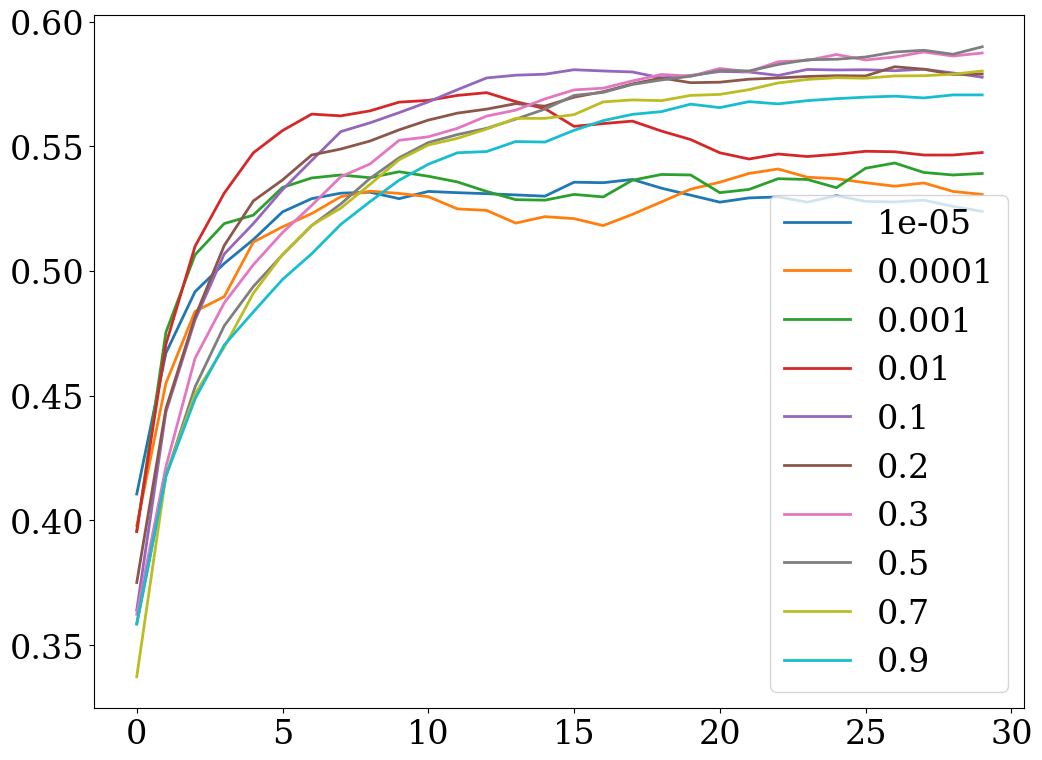

In [46]:

from matplotlib import pylab as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24


for i in range(len(lambdas)):
    plt.plot(data[i], label=str(lambdas[i]))
    plt.legend()

In [10]:
def objective(trial):
    n = 3
    x = []
    for i in range(n):
        x.append(- np.log(trial.suggest_float(f"x_{i}", 0, 1)))

    coeff = []
    for i in range(n):
        coeff.append(x[i] / sum(x))
        
    crit = nn.CrossEntropyLoss()
    lam1 = 0.1
    student = Cifar_Very_Tiny(10).to(device)
    
    my_feat = [Mutual_Info(8, 16).to(device),
               Mutual_Info(16, 32).to(device),
               Mutual_Info(32, 64).to(device),
               ]
    
    log_sigma_feat = [torch.nn.Parameter(torch.zeros(1).to(device)),
                      torch.nn.Parameter(torch.zeros(1).to(device)),
                      torch.nn.Parameter(torch.zeros(1).to(device)),
                    ]
    
    optim = torch.optim.Adam(list(student.parameters()) + list(my_feat[0].parameters()) + list(my_feat[1].parameters()) + list(my_feat[2].parameters()) +log_sigma_feat)    
    tq = tqdm(range(epoch_num))
    for epoch in tq:
        losses = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optim.zero_grad()
            
            
            *student_feat, student_logits = student.get_features(x, [0, 1, 2, 4])
            teacher_feat = teacher.get_features(x, [0, 1, 2])
            
            feat_loss_sum = 0
            for i in range(3):
                my_stud_feat = my_feat[i](student_feat[i])
                my_stud_feat = my_stud_feat.view(my_stud_feat.size(0), -1)
                my_teacher_feat = teacher_feat[i].view(teacher_feat[i].size(0), -1)
                
                sigma2 = torch.log(1 + torch.exp(log_sigma_feat[i]))
                feat_loss = ((my_teacher_feat - my_stud_feat) ** 2).sum(
                    1
                ).mean() / 2 * sigma2 + 0.5*torch.log(sigma2)
                feat_loss_sum += coeff[i] * feat_loss
                
            class_loss = crit(student_logits, y)
            loss = class_loss * (1.0-lam1) + feat_loss * lam1

            loss.backward()
            optim.step()
            losses.append(loss.detach().cpu().numpy())
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:]))) 
        #scheduler.step()
        student.eval()
        ac = accuracy(student)
        student.train()
        with open('../logs/acc_pairs_coeffs_mi.txt','a') as out:
            out.write('[{},{},{}]: {}: {}\n'.format(*coeff, epoch, ac))
    return ac

In [14]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=15)

[I 2023-04-04 09:48:29,503] A new study created in memory with name: no-name-fd8afc10-1125-437f-91f4-da13b6a79e19


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:49:51,788] Trial 0 finished with value: 0.5841000080108643 and parameters: {'x_0': 0.28956803223016025, 'x_1': 0.6588757045517659, 'x_2': 0.44666380060503086}. Best is trial 0 with value: 0.5841000080108643.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:51:13,128] Trial 1 finished with value: 0.5746999979019165 and parameters: {'x_0': 0.40184954015022967, 'x_1': 0.521174103669755, 'x_2': 0.8368807098971548}. Best is trial 0 with value: 0.5841000080108643.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:52:31,883] Trial 2 finished with value: 0.5827000141143799 and parameters: {'x_0': 0.35194050566832746, 'x_1': 0.9746312538005888, 'x_2': 0.6499174573492632}. Best is trial 0 with value: 0.5841000080108643.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:53:52,434] Trial 3 finished with value: 0.5787999629974365 and parameters: {'x_0': 0.08852321692302711, 'x_1': 0.6537929596999387, 'x_2': 0.906011966133933}. Best is trial 0 with value: 0.5841000080108643.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:55:12,909] Trial 4 finished with value: 0.5884999632835388 and parameters: {'x_0': 0.4260388124602188, 'x_1': 0.7824271635826903, 'x_2': 0.9471700534242649}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:56:33,494] Trial 5 finished with value: 0.5798999667167664 and parameters: {'x_0': 0.04409511444831549, 'x_1': 0.4569476062820296, 'x_2': 0.999926028374534}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:57:55,450] Trial 6 finished with value: 0.5776999592781067 and parameters: {'x_0': 0.7887023951015047, 'x_1': 0.7723981287664073, 'x_2': 0.6304207290746137}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 09:59:16,525] Trial 7 finished with value: 0.5602999925613403 and parameters: {'x_0': 0.3059625015482149, 'x_1': 0.9838721509684724, 'x_2': 0.6914461353966617}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 10:00:38,271] Trial 8 finished with value: 0.5737000107765198 and parameters: {'x_0': 0.6364243255437866, 'x_1': 0.6582466343444445, 'x_2': 0.843263118178245}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 10:01:59,837] Trial 9 finished with value: 0.5672999620437622 and parameters: {'x_0': 0.13695290383968894, 'x_1': 0.3313239420170595, 'x_2': 0.947149426690415}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 10:03:21,557] Trial 10 finished with value: 0.5575000047683716 and parameters: {'x_0': 0.3813879393069237, 'x_1': 0.9699489218113063, 'x_2': 0.20526998062746704}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 10:04:43,453] Trial 11 finished with value: 0.5771999955177307 and parameters: {'x_0': 0.3587498569001919, 'x_1': 0.04279313814206831, 'x_2': 0.7663561194116981}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 10:06:04,630] Trial 12 finished with value: 0.573199987411499 and parameters: {'x_0': 0.6000117407371993, 'x_1': 0.49411332306544864, 'x_2': 0.9196801494435032}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 10:07:26,253] Trial 13 finished with value: 0.5770999789237976 and parameters: {'x_0': 0.21381955713499523, 'x_1': 0.5662075800967296, 'x_2': 0.12565290167219134}. Best is trial 4 with value: 0.5884999632835388.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-04 10:08:49,691] Trial 14 finished with value: 0.5978999733924866 and parameters: {'x_0': 0.2717201804601215, 'x_1': 0.027357277484890807, 'x_2': 0.08004439796956353}. Best is trial 14 with value: 0.5978999733924866.


In [4]:
path = '../logs/acc_pairs_coeffs_mi.txt'

with open(path, "r") as read_file:
    data = [float(line.split()[2]) for line in read_file]
data = np.reshape(np.array(data), (-1, epoch_num))

In [5]:
with open(path, "r") as read_file:
    labels = [line.split()[0][:4] for line in read_file]
labels = np.reshape(np.array(labels), (-1, epoch_num))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

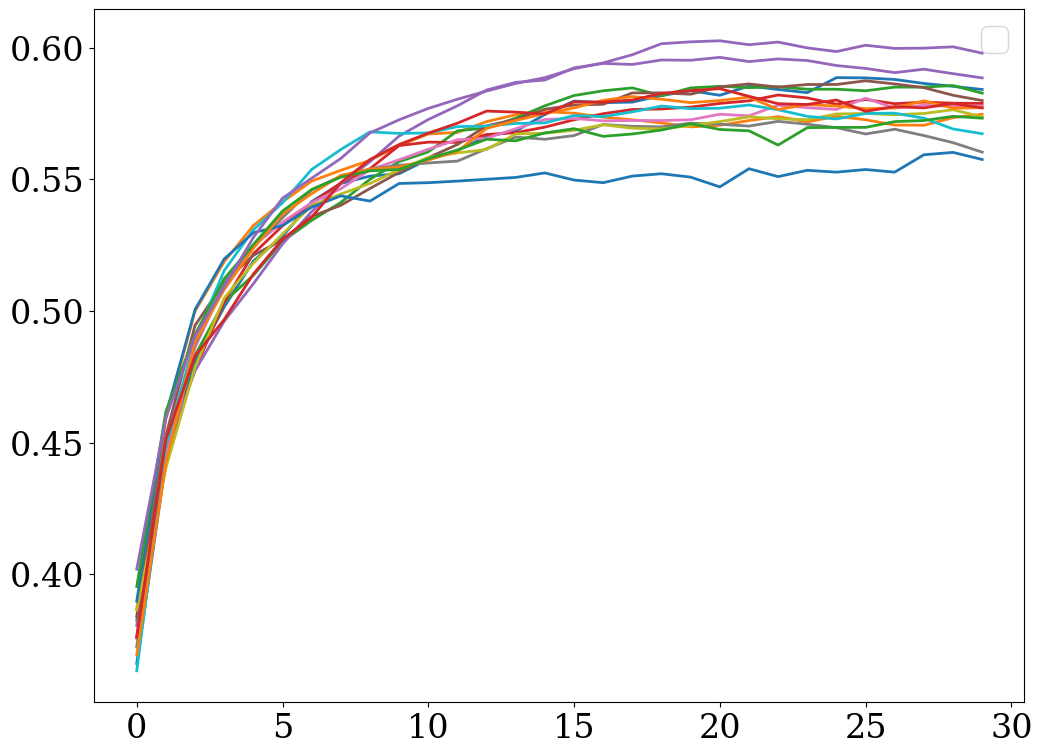

In [21]:

from matplotlib import pylab as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24


for i in range(len(labels)):
    plt.plot(data[i])

plt.xlabel('')

Практически 0.60 на тесте, больше, чем учитель) 
Но в следующих экспах по дистилляции такого результата не достигли, хотя там больше всего намешано